
# Event-Driven Backtesting System Demonstration

This notebook demonstrates how to use an event-driven backtesting system with provided example data. 
The following sections will cover:

1. Loading the required data files (event signals, stock prices, TAIEX index data).
2. Initializing and running the backtesting system.
3. Calculating and visualizing the backtesting results.

---


In [1]:
from collections import defaultdict
from collections import deque
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.extend(['../', '../../'])
from src.backtest import EventBacktester
from src.metrics import MetricsCalculator
from src.utils import load_data, trade_conditions

# File paths (adjust these paths if necessary)
events_path = r'C:\Users\User\Desktop\event-trading\notebooks\events.csv'
prices_path = r'C:\Users\User\Desktop\event-trading\notebooks\prices.csv'
taiex_path = r'C:\Users\User\Desktop\event-trading\notebooks\TAIEX.csv'


### Load Data

In [2]:

# Load the events, prices, and TAIEX data
events_df = pd.read_csv(events_path)
prices_df = pd.read_csv(prices_path)
taiex_df = pd.read_csv(taiex_path)

# Convert datetime columns to actual datetime type and set as index
events_df['datetime'] = pd.to_datetime(events_df['datetime'])
prices_df['datetime'] = pd.to_datetime(prices_df['datetime'])
taiex_df['datetime'] = pd.to_datetime(taiex_df['datetime'])

events_df.set_index('datetime', inplace=True)
prices_df.set_index('datetime', inplace=True)
taiex_df.set_index('datetime', inplace=True)

# Only keep the closing prices as a Series in TAIEX data
taiex_returns = taiex_df['指數收盤價'].pct_change().fillna(0)


In [3]:
events_df.head()

,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,28.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,26.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,31.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,28.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,71.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
prices_df.head()

,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-02,39.00,37.45,13.85,16.15,6.71,10.70,13.95,38.55,20.25,26.90,...,16.55,62.7,19.05,20.5,19.2,42.3,29.10,13.50,17.25,12.70
2013-01-03,38.85,37.50,13.90,16.35,6.80,10.65,14.05,38.50,20.40,26.80,...,16.60,67.0,18.95,20.2,19.2,42.2,29.25,13.35,17.30,12.85
2013-01-04,39.00,37.20,13.80,16.65,6.92,10.65,13.80,38.35,20.25,26.90,...,16.55,66.1,19.10,20.3,19.4,41.6,29.25,13.15,17.30,13.00
2013-01-07,38.90,37.00,13.90,17.00,7.02,10.70,14.00,39.60,20.65,27.15,...,17.20,65.6,19.50,20.0,19.5,41.7,29.40,13.45,17.20,12.85
2013-01-08,38.50,36.85,13.95,17.10,6.98,10.55,14.05,39.15,20.40,27.20,...,17.50,64.5,19.25,19.8,19.3,41.7,28.95,13.25,17.10,12.80


In [5]:
taiex_df.head()

,指數收盤價
datetime,
2013-01-02,7779.22
2013-01-03,7836.84
2013-01-04,7805.99
2013-01-07,7755.09
2013-01-08,7721.66


### Initialize and Apply Trade Conditions

In [22]:
# 買入訊號條件改為該row最小的10%，買入若連續後五個交易日無心買入訊號給出賣出訊號

import pandas as pd
import numpy as np

def trade_conditions(df):
    """
    整體處理DataFrame生成交易訊號
    - 最低10%分位數產生買入訊號
    - 最後一次買入後的22個交易日內沒有新的買入訊號，則在第22天產生賣出訊號
    - 在最後一天未達到22天的情況下，仍需賣出尚持有的股票
    
    Args:
        df: 原始DataFrame
    Returns:
        包含 'buy'、'sell' 或 NaN 的DataFrame
    """
    # 建立結果DataFrame
    result = pd.DataFrame(index=df.index, columns=df.columns)
    
    # 對每一行計算10%分位數並標記買入點
    for date in df.index:
        row = df.loc[date]
        valid_values = row[pd.notna(row)]
        if len(valid_values) > 0:
            threshold = valid_values.quantile(0.1)
            # 標記買入點
            buy_signals = row <= threshold
            result.loc[date, buy_signals] = 'buy'
            
    # 對每一個股票處理賣出訊號
    for column in df.columns:
        buy_dates = result.index[result[column] == 'buy'].tolist()
        
        for buy_date in buy_dates:
            # 獲取買入日期之後的22個交易日
            buy_idx = df.index.get_loc(buy_date)
            next_22_days = df.index[buy_idx+1:buy_idx+23]  # 往後取22個交易日
            
            if len(next_22_days) >= 22:  # 確保有足夠的後續交易日
                # 檢查這22天內是否有新的買入訊號
                has_new_buy = False
                for day in next_22_days[:21]:  # 只檢查前21天
                    if result.loc[day, column] == 'buy':
                        has_new_buy = True
                        break
                
                # 如果22天內沒有新的買入訊號，在第22天標記賣出
                if not has_new_buy:
                    result.loc[next_22_days[21], column] = 'sell'
                    
        # 在最後一天強制賣出所有尚未賣出的買入訊號
        last_buy_date = result.index[result[column] == 'buy'].tolist()[-1] if 'buy' in result[column].values else None
        if last_buy_date:
            last_idx = df.index.get_loc(last_buy_date)
            if last_idx < len(df.index) - 1:
                result.loc[df.index[-1], column] = 'sell'

    # 將未標記的位置填入NaN
    result = result.fillna(np.nan)
    return result

# 假設 events_df 是您的 DataFrame
trade_conditions(events_df).head(30)









C:\Users\User\AppData\Local\Temp\ipykernel_32104\3344384898.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result.fillna(np.nan)


,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#test
def trade_conditions2(row):
    new_row = row.copy()
    for symbol in row.index:
        if pd.notna(row[symbol]):
            new_row[symbol] = "buy"
        # 如果是 NaN，就保持原值（不改動）
    return new_row

In [23]:

# Initialize the backtesting system
backtester = EventBacktester(events_df=events_df, prices_df=prices_df, trade_conditions=trade_conditions)

# Apply trade conditions to convert events to buy/sell signals
backtester.df_trade_conditions()
backtester.events_df.head()  # Display the updated events_df with signals


C:\Users\User\AppData\Local\Temp\ipykernel_32104\3344384898.py:60: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result.fillna(np.nan)


,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
datetime,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
backtester.events_df.tail(30)

,1101,1102,1103,1104,1108,1109,1110,1201,1203,1210,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
datetime,,,,,,,,,,,,,,,,,,,,,
2024-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-16,sell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Execute Trades

In [25]:

# Execute the trades based on signals
backtester.execute_trades()

# Display the trades executed
pd.DataFrame(backtester.trades).head(30)


,date,stock_code,action,amount,price,fee,pnl
0,2013-01-03,2002,buy,1,28.10,0.024026,-0.024026
1,2013-01-03,2303,buy,1,12.35,0.010559,-0.010559
2,2013-01-03,2311,buy,1,26.80,0.022914,-0.022914
3,2013-01-03,2317,buy,1,89.10,0.076180,-0.076180
4,2013-01-03,2330,buy,1,101.00,0.086355,-0.086355
5,2013-01-03,2409,buy,1,13.75,0.011756,-0.011756
6,2013-01-03,2881,buy,1,35.30,0.030181,-0.030181
7,2013-01-03,2886,buy,1,23.10,0.019751,-0.019751
8,2013-01-03,2890,buy,1,12.75,0.010901,-0.010901
9,2013-01-03,3481,buy,1,16.80,0.014364,-0.014364


In [26]:
sell_df = pd.DataFrame(backtester.trades)[pd.DataFrame(backtester.trades)['action'] == 'sell']
sell_df.tail(50)

,date,stock_code,action,amount,price,fee,pnl
29511,2024-08-12,2449,sell,4,118.50,1.827270,-4.234250
29546,2024-08-15,2801,sell,2,17.40,0.134154,-2.666046
29552,2024-08-16,2356,sell,10,47.55,1.833052,-99.022284
29580,2024-08-20,3037,sell,3,158.00,1.827270,-123.335995
29581,2024-08-21,1102,sell,1,44.25,0.170584,2.293720
29582,2024-08-21,1402,sell,2,36.80,0.283728,3.806892
29616,2024-08-26,2610,sell,21,20.85,1.687912,-42.847115
29696,2024-09-05,2344,sell,1,21.40,0.082497,-1.802248
29714,2024-09-06,2892,sell,2,27.05,0.208556,-3.907932
29719,2024-09-09,2834,sell,1,15.45,0.059560,-0.222898


In [27]:
df_2353 = pd.DataFrame(backtester.trades)[pd.DataFrame(backtester.trades)['stock_code'] == '2353']
df_2353.tail(30)

,date,stock_code,action,amount,price,fee,pnl
28258,2024-02-16,2353,buy,1,48.65,0.041596,-0.041596
28268,2024-02-19,2353,buy,1,47.40,0.040527,-0.040527
28278,2024-02-20,2353,buy,1,47.40,0.040527,-0.040527
28298,2024-02-22,2353,buy,1,46.85,0.040057,-0.040057
28341,2024-02-29,2353,buy,1,45.15,0.038603,-0.038603
28351,2024-03-01,2353,buy,1,46.00,0.039330,-0.039330
28363,2024-03-04,2353,buy,1,45.85,0.039202,-0.039202
28423,2024-03-12,2353,buy,1,47.05,0.040228,-0.040228
28518,2024-03-25,2353,buy,1,46.50,0.039758,-0.039758
28623,2024-04-10,2353,buy,1,47.15,0.040313,-0.040313


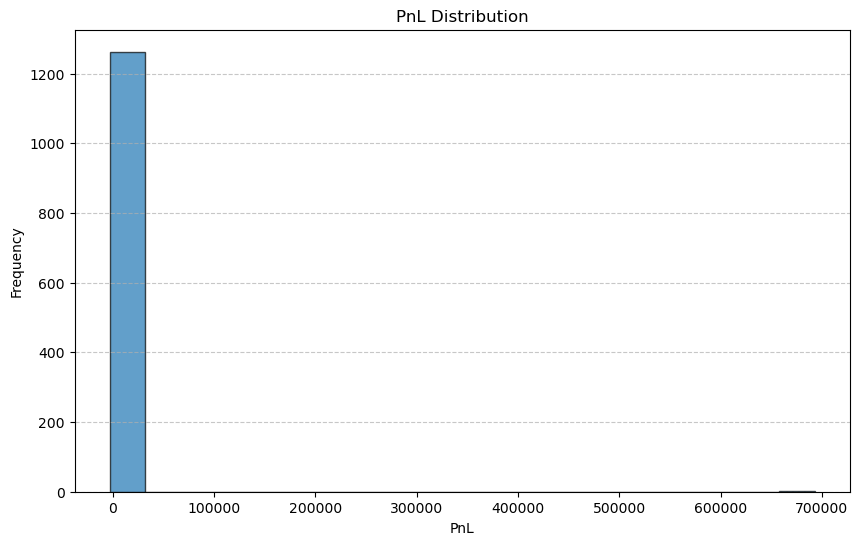

In [29]:
# 繪製 PnL 分佈圖

plt.figure(figsize=(10, 6))
plt.hist(sell_df['pnl'], bins=20, edgecolor='black', alpha=0.7)
plt.title('PnL Distribution')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

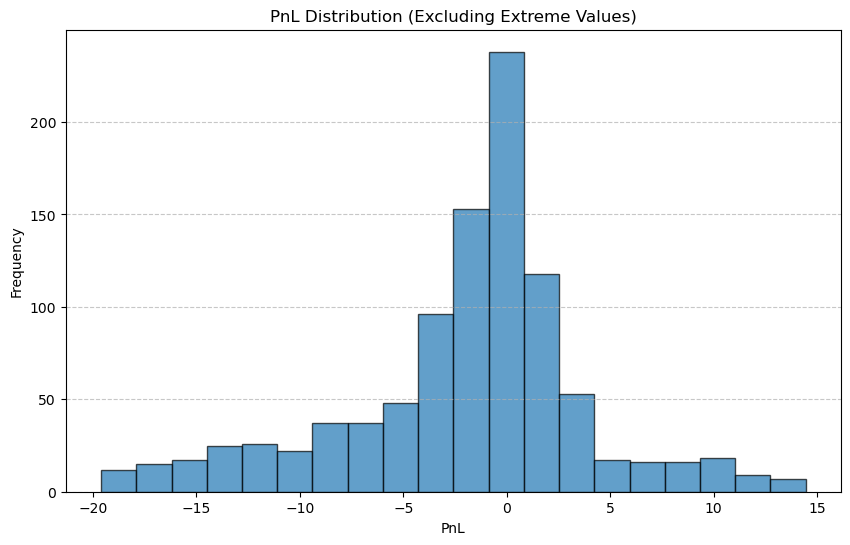

In [30]:
# 假設 df 是包含 PnL 數據的 DataFrame
Q1 = sell_df['pnl'].quantile(0.25)
Q3 = sell_df['pnl'].quantile(0.75)
IQR = Q3 - Q1

# 篩選掉極端值，只保留在 (Q1 - 1.5*IQR) 和 (Q3 + 1.5*IQR) 之間的數據
filtered_df = sell_df[(sell_df['pnl'] >= Q1 - 1.5 * IQR) & (sell_df['pnl'] <= Q3 + 1.5 * IQR)]

# 繪製排除極端值的 PnL 分佈圖
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['pnl'], bins=20, edgecolor='black', alpha=0.7)
plt.title('PnL Distribution (Excluding Extreme Values)')
plt.xlabel('PnL')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [33]:
df = sell_df
Q1 = df['pnl'].quantile(0.25)
Q3 = df['pnl'].quantile(0.75)
IQR = Q3 - Q1

# 計算異常值範圍
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR

# 篩選出極端值行（即 PnL 小於 lower_bound 或大於 upper_bound 的行）
extreme_rows = df[(df['pnl'] < lower_bound) | (df['pnl'] > upper_bound)]

# 查看結果
extreme_rows


,date,stock_code,action,amount,price,fee,pnl
722,2013-04-24,2324,sell,12,18.85,0.872001,-26.136820
793,2013-05-06,2308,sell,4,145.50,2.243610,76.826752
797,2013-05-06,2474,sell,1,160.00,0.616800,19.263500
877,2013-05-16,1216,sell,16,59.80,3.688464,50.340326
995,2013-05-31,2498,sell,4,276.50,4.263630,-33.733627
...,...,...,...,...,...,...,...
30081,2024-10-30,2609,sell,42,66.40,10.750824,-30.800339
30083,2024-10-30,2615,sell,5,85.70,1.651868,-59.867654
30084,2024-10-30,2618,sell,482,37.35,69.400408,2495.311387
30086,2024-10-30,2882,sell,46,68.90,12.218037,311.100642


In [34]:
sorted_df = extreme_rows.sort_values(by='pnl', ascending=False)

# 查看結果
sorted_df

,date,stock_code,action,amount,price,fee,pnl
21327,2021-05-21,2330,sell,1931,573.00,4265.414865,692761.216092
25441,2022-12-26,2603,sell,420,162.50,263.103750,31726.670241
21253,2021-05-12,2317,sell,1525,102.00,599.645250,22308.342711
28824,2024-05-08,2382,sell,129,273.50,136.010182,8334.986420
30078,2024-10-30,2409,sell,2196,16.60,140.528628,6529.097829
...,...,...,...,...,...,...,...
18322,2020-03-17,2408,sell,51,54.10,10.636330,-1034.568060
27816,2023-12-11,2301,sell,52,110.50,22.150830,-1137.512283
16402,2019-06-14,2344,sell,183,14.10,9.947056,-1145.621501
25707,2023-02-13,2609,sell,64,59.00,14.556480,-1690.914264


### Calculate Metrics

In [35]:

# Initialize metrics calculator with trades and TAIEX returns
metrics_calculator = MetricsCalculator(pd.DataFrame(backtester.trades))
metrics_calculator.taiex_returns = taiex_returns

# Calculate cumulative returns and other metrics
cumulative_returns = metrics_calculator.calculate_cumulative_returns()
metrics = metrics_calculator.calculate_all_metrics()

# Display metrics
metrics


c:\Users\User\Desktop\event-trading\notebooks\..\src\metrics.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  taiex_cumulative = taiex_cumulative.reindex(self.trades_df['date'].drop_duplicates()).fillna(method='ffill')


{'PnL': -1343.4530207500059,
 'Sharpe Ratio': -0.3027697694036365,
 'CAGR': 2.1388022914929623,
 'MDD': -3.4553020227703106}

### Plot Cumulative Returns

In [12]:

# Plot the cumulative returns
metrics_calculator.plot_cumulative_returns()
plt.show()


TypeError: MetricsCalculator.plot_cumulative_returns() missing 1 required positional argument: 'cumulative_returns'